In [ ]:
%%capture
!pip install pygments

In [ ]:
import re
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

from pygments import lex
from pygments.lexers import CppLexer
from pygments.token import Token

from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, roc_curve

from scipy.spatial.distance import euclidean, correlation

from transformers import AutoModel, AutoTokenizer
import torch

# Utils

In [ ]:
def remove_cpp_comments(code):
    lexer = CppLexer()
    tokens = lex(code, lexer)
    result = []
    for token_type, token_value in tokens:
        if token_type not in Token.Comment:
            result.append(token_value)
        else:
            result.append('\n')
    return ''.join(result).strip()


def get_code_pieces(raw_code, remove_comments=True):
    pattern = re.compile(r"```\w+(.*?)```", re.DOTALL)
    return [remove_cpp_comments(val) if remove_comments else val
            for val in pattern.findall(raw_code)]


cpp_code_with_comments = '''
Мяу
// This is a comment
```cpp
#include <iostream>

/* This is a
   multiline comment */
int main() {
    std::cout << "Hello, // World!" << std::endl; // This is an inline comment
    return 0;
}
```
```c
int main2 {

}
```
'''
get_code_pieces(cpp_code_with_comments)

['int main() {\n    std::cout << "Hello, // World!" << std::endl; \n    return 0;\n}',
 'int main2 {\n\n}']

In [ ]:
def print_info(df, title="Dataframe"):
    display(HTML(f"<b>{title}</b>"))
    print(f"Кол-во строк: {df.shape[0]}, кол-во столбцов: {df.shape[1]}")
    display(pd.concat([df.dtypes.to_frame('Data type'),
                    df.isna().sum().to_frame('Count NaN'),
                    df.nunique().to_frame('Count unique')], axis=1).T)
    print("Sample rows:")
    display(df.sample(5))
    print()

# Data

На исходных несбалансированных данных

In [ ]:
def read_data(path='/content/drive/MyDrive/Курсеки/Studcamp/Проект/'):
    csv_path_1 = path + 'data/codellama_with_code_and_signature_0-6_status.csv'
    csv_path_2 = path + 'data/bench-v0.6.csv'
    json_path = path + 'data/bench-v0.6.json'

    df1 = pd.read_csv(csv_path_1)
    df2 = pd.read_csv(csv_path_2)[['Unnamed: 0', 'fname', 'doc']]
    df3 = pd.read_json(json_path).T['code'].reset_index()

    merged_df2_df3 = pd.merge(df2, df3, left_on='Unnamed: 0', right_on='index').drop(columns='Unnamed: 0')

    final_df = pd.merge(df1, merged_df2_df3, left_on='Unnamed: 0', right_on='index').drop(columns='Unnamed: 0')

    return final_df

In [ ]:
data = read_data()
print_info(data)
# data.to_csv('/content/drive/MyDrive/Курсеки/Studcamp/Проект/data/merged.csv', index=False)

Кол-во строк: 214, кол-во столбцов: 35


,repository,1,build_1_status,passed_1_status,0,build_0_status,passed_0_status,6,build_6_status,passed_6_status,...,5,build_5_status,passed_5_status,4,build_4_status,passed_4_status,fname,doc,index,code
Data type,object,object,bool,bool,object,bool,bool,object,bool,bool,...,object,bool,bool,object,bool,bool,object,object,object,object
Count NaN,0,2,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Count unique,4,199,2,2,187,2,2,205,2,2,...,205,2,2,208,2,2,212,214,214,214


Sample rows:


,repository,1,build_1_status,passed_1_status,0,build_0_status,passed_0_status,6,build_6_status,passed_6_status,...,5,build_5_status,passed_5_status,4,build_4_status,passed_4_status,fname,doc,index,code
163,redis,"void dictRehashingInfo(dict *d, unsigned long ...",False,False,typedef struct dictEntry {\n void *key;\n ...,False,False,typedef struct dictEntry {\n void *key;\n ...,False,False,...,"void dictRehashingInfo(dict *d, unsigned long ...",False,False,"void dictRehashingInfo(dict *d, unsigned long ...",False,False,dictRehashingInfo,Provides the old and new ht size for a given d...,2F6791789BCEDFFA,"void dictRehashingInfo(dict *d, unsigned long ..."
132,openssl,static ossl_inline int compute_growth(int targ...,True,False,static ossl_inline int compute_growth(int targ...,True,True,static ossl_inline int compute_growth(int targ...,True,False,...,static ossl_inline int compute_growth(int targ...,True,True,static ossl_inline int compute_growth(int targ...,False,False,compute_growth,\n Calculate the array growth based on the tar...,AE5A8AC3C44BCAB7,static ossl_inline int compute_growth(int targ...
2,llvm,unsigned newRegUnit(unsigned Weight) {\n //...,True,False,using namespace std;\n\nstruct RegisterUnit {\...,True,False,unsigned newRegUnit(unsigned Weight) {\n //...,True,False,...,unsigned newRegUnit(unsigned Weight) {\n unsi...,True,False,unsigned newRegUnit(unsigned Weight) {\n //...,True,False,llvm::CodeGenRegBank::newRegUnit,Create a new non-native register unit that can...,292D96CBB32F5AF6,unsigned newRegUnit(unsigned Weight) {\n ...
203,redis,static unsigned long evictionTimeLimitUs(void)...,False,False,static unsigned long evictionTimeLimitUs(void)...,True,True,static unsigned long evictionTimeLimitUs(void)...,False,False,...,static unsigned long evictionTimeLimitUs(void)...,True,True,static unsigned long evictionTimeLimitUs(void)...,True,True,evictionTimeLimitUs,Algorithm for converting tenacity (0-100) to a...,0CBA565430D94C57,static unsigned long evictionTimeLimitUs(void)...
156,redis,int kvstoreGetFairRandomDictIndex(kvstore *kvs...,False,False,int kvstoreGetFairRandomDictIndex(kvstore *kvs...,False,False,typedef struct kvstore {\n int num_dicts;\n...,False,False,...,int kvstoreGetFairRandomDictIndex(kvstore *kvs...,False,False,int kvstoreGetFairRandomDictIndex(kvstore *kvs...,False,False,kvstoreGetFairRandomDictIndex,"Returns fair random dict index, probability of...",53097E4BA66791C4,int kvstoreGetFairRandomDictIndex(kvstore *kvs...


<Axes: >

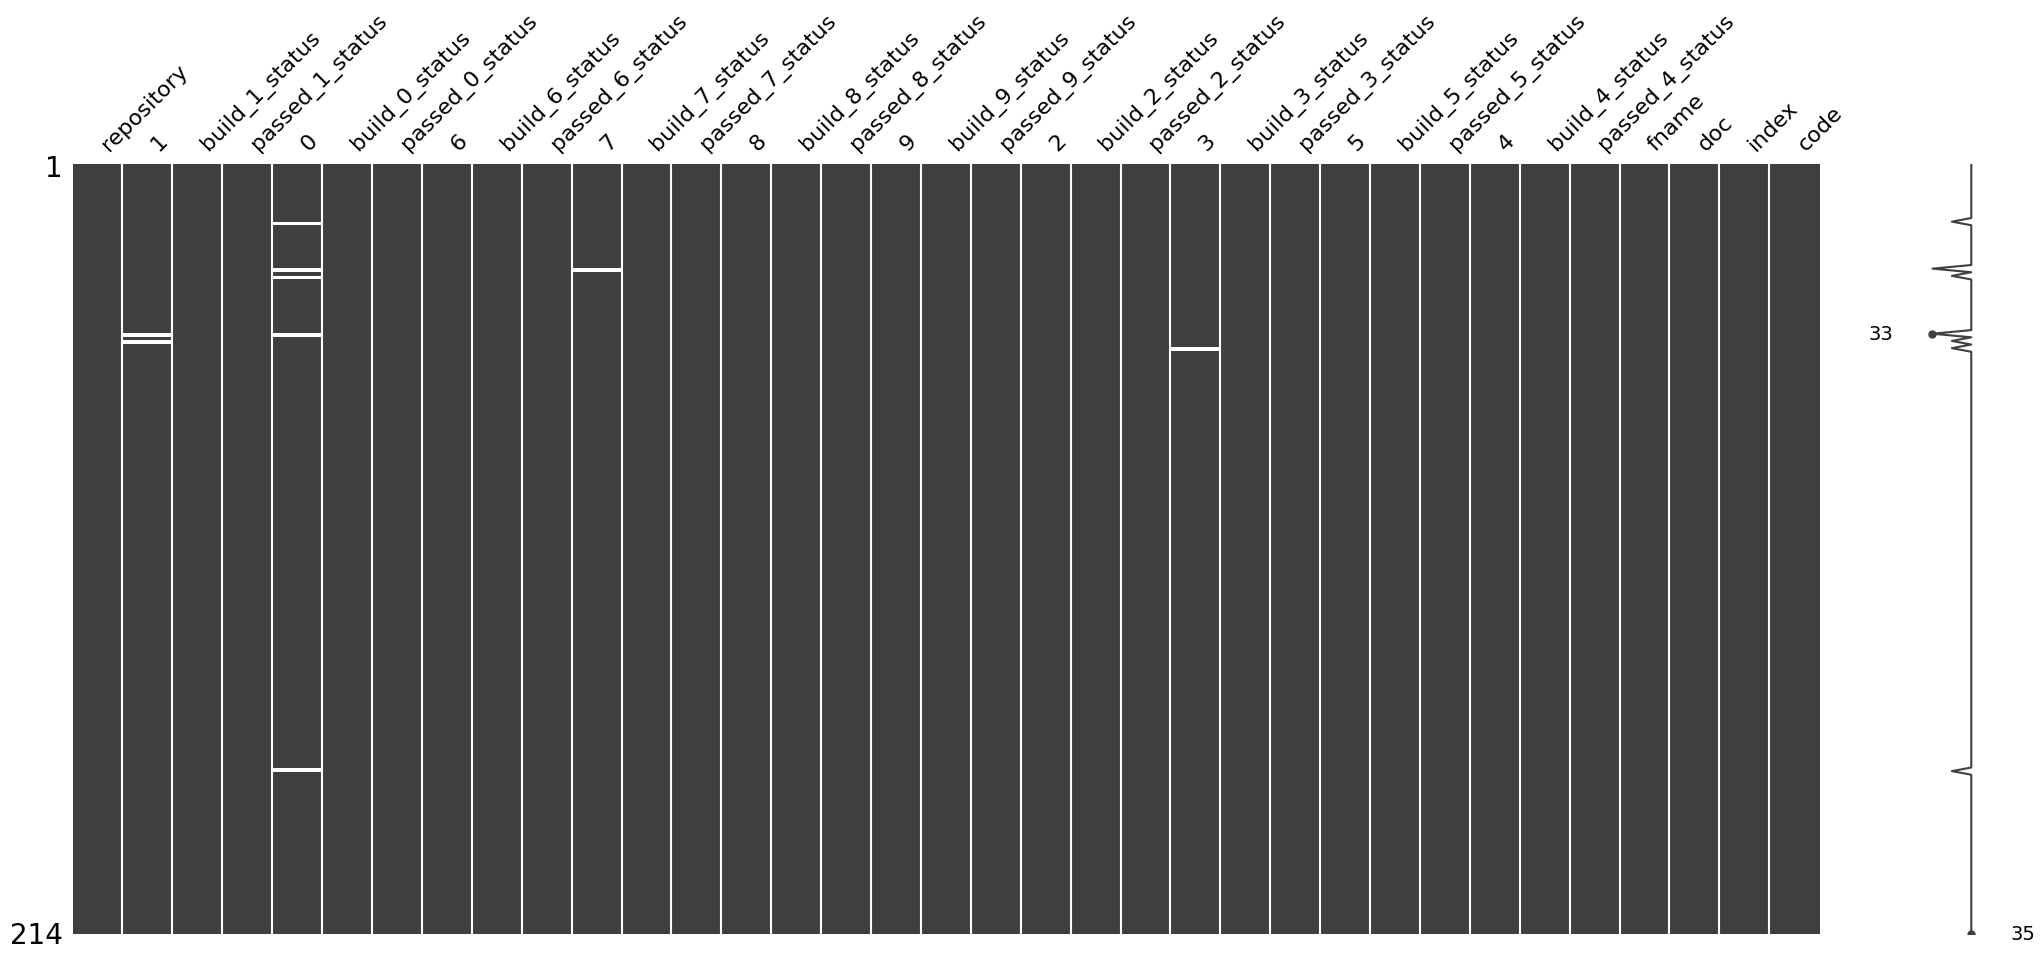

In [ ]:
import missingno as msno

msno.matrix(data)

Что будет, если предсказывать, что код написан человеком, только тогда, когда он прошел и билд, и тесты

In [ ]:
cringe_data = []
for i, row in data.iterrows():
    for num in range(10):
        cringe_data.append([row['index'], row[f'build_{num}_status'], row[f'passed_{num}_status'], False]) # llm
    cringe_data.append([row['index'], True, True, True])  # human
cringe_df = pd.DataFrame(cringe_data, columns=['index', 'build_passed', 'tests_passed', 'target']).set_index('index')
cringe_df['all_passed'] = cringe_df['build_passed'] & cringe_df['tests_passed']

In [ ]:
(cringe_df['target'] == cringe_df['all_passed']).value_counts()

True     2210
False     144
Name: count, dtype: int64

# Embedders

In [ ]:
class Embedder:
    def __init__(self, checkpoint):
        self.checkpoint = checkpoint
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
        self.max_length = self.tokenizer.model_max_length
        self.model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(self.device)

    def __str__(self):
        return self.checkpoint

    def _chunk_text(self, text, max_length):
        tokens = self.tokenizer.encode(text, return_tensors="pt")
        return [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    def _mean_pooling(self, embeddings):
        return torch.mean(embeddings, dim=0)

    def _get_embeddings_t5(self, texts):
        embeddings = []
        for text in texts:
            chunks = self._chunk_text(text, self.max_length)
            chunk_embeddings = []
            for chunk in chunks:
                inputs = chunk.to(self.device)
                embedding = self.model(inputs)[0]
                chunk_embeddings.append(embedding)
            pooled_embedding = self._mean_pooling(torch.stack(chunk_embeddings))
            embeddings.append(pooled_embedding)
        return torch.stack(embeddings)

    def _get_embeddings_jinaai(self, texts):
        return torch.tensor(self.model.encode(texts))

    def get_embeddings(self, texts):
        if not isinstance(texts, list):
            texts = [texts]
        match self.checkpoint:
            case "Salesforce/codet5p-110m-embedding":
                return self._get_embeddings_t5(texts)
            case "jinaai/jina-embeddings-v2-base-code":
                return self._get_embeddings_jinaai(texts)
            case _:
                raise ValueError(f"Unknown model {self.checkpoint}!")

In [ ]:
embedder = Embedder("jinaai/jina-embeddings-v2-base-code")
embeddings = embedder.get_embeddings([
    """
    typedef struct streamID {
    long long id;
} streamID;

typedef struct stream {
    char *name;
    size_t namelen;
    streamID *id;
    long long entries_read;
} stream;

typedef struct streamCG {
    stream *s;
    char *name;
    size_t namelen;
    streamID *id;
    long long entries_read;
} streamCG;

streamCG *streamCreateCG(stream *s, char *name, size_t namelen, streamID *id, long long entries_read) {
    streamCG *cg = malloc(sizeof(streamCG));
    if (cg == NULL) {
        return NULL;
    }
    cg->s = s;
    cg->name = name;
    cg->namelen = namelen;
    cg->id = id;
    cg->entries_read = entries_read;
    return cg;
}
    """,
    """
    static int obj_new_nid_unlocked(int num)
{
    int nid;

    if (TSAN_REQUIRES_LOCKING) {
        ossl_obj_lock();
    }

    nid = obj_new_nid(num);

    if (TSAN_REQUIRES_LOCKING) {
        ossl_obj_unlock();
    }

    return nid;
}
    """
])
embeddings.shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/971k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.53k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-v2-qk-post-norm:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/root/.cache/huggingface/modules/transformers_modules/jinaai/jina-bert-v2-qk-post-norm/3baf9e3ac750e76e8edd3019170176884695fb94/configuration_bert.py:29: UserWarning: optimum is not installed. To use OnnxConfig and BertOnnxConfig, make sure that `optimum` package is installed
  warnings.warn("optimum is not installed. To use OnnxConfig and BertOnnxConfig, make sure that `optimum` package is installed")


modeling_bert.py:   0%|          | 0.00/96.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-v2-qk-post-norm:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/322M [00:00<?, ?B/s]

torch.Size([2, 768])

In [ ]:
target_columns = ['code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
data_with_embeddings = []

for embedder_checkpoint in tqdm(["Salesforce/codet5p-110m-embedding", "jinaai/jina-embeddings-v2-base-code"]):
    embedder = Embedder(embedder_checkpoint)
    for row_num in tqdm(range(data.shape[0])):
        for col in target_columns:
            code = data.iloc[row_num][col]
            code = '' if not isinstance(code, str) else code
            data_with_embeddings.append({'index': data.iloc[row_num]['index'], 'embedder_checkpoint': embedder_checkpoint,
                                          'col': col, 'embedding': embedder.get_embeddings(code).cpu().detach().numpy()})

In [ ]:
# pd.DataFrame(data_with_embeddings).to_csv('/content/drive/MyDrive/Курсеки/Studcamp/Проект/data/data_with_embeddings.csv', index=False)

# Manual Similarity

In [ ]:
def plot_distances(similarity_matrix, target_columns, title='Similarity Heatmap'):
    fig = go.Figure(data=go.Heatmap(
        z=similarity_matrix,
        x=target_columns,
        y=target_columns,
        colorscale='Greens',
        text=np.round(similarity_matrix, 2).astype(str),
        hovertemplate='%{y}, %{x}: %{text:.2f}<extra></extra>',
        texttemplate="%{text:.2f}",
        textfont={"size": 12},
    ))
    fig.update_layout(
        title=title,
        xaxis_nticks=36
    )
    fig.show()

В этих данных оставлены комменты и всё то, что не код

In [ ]:
metrics = {
    'Cosine Similarity': lambda a, b: cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0],
    'Euclidean Distance': lambda a, b: euclidean(a.flatten(), b.flatten()),
    'Pearson Correlation Coefficient': lambda a, b: correlation(a.flatten(), b.flatten()),
}

target_columns = ['code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
length = len(target_columns)

for embedder_checkpoint in ["Salesforce/codet5p-110m-embedding", "jinaai/jina-embeddings-v2-base-code"]:
    embedder = Embedder(embedder_checkpoint)
    for metric_name in ['Cosine Similarity', 'Euclidean Distance', 'Pearson Correlation Coefficient']:
        metric_func = metrics[metric_name]

        similarity_matricies = []
        for row_num in range(data.shape[0]):
            embeddings = []
            for col in target_columns:
                code = data.iloc[row_num][col]
                code = '' if not isinstance(code, str) else code
                embeddings.append(embedder.get_embeddings(code).cpu().detach().numpy())

            similarity_matrix = np.zeros((length, length))
            for i in range(length):
                for j in range(length):
                    if i == j:
                        similarity_matrix[i, j] = np.nan
                    else:
                        similarity_matrix[i, j] = metric_func(embeddings[i], embeddings[j])
            similarity_matricies.append(similarity_matrix)

        plot_distances(np.nanmean(similarity_matricies, axis=0), target_columns,
                      title=f"Embedder: {embedder_checkpoint}, metric: {metric_name}, mean by all data")

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-12-a728553784a9>:39: RuntimeWarning:

Mean of empty slice



/root/.cache/huggingface/modules/transformers_modules/jinaai/jina-bert-v2-qk-post-norm/3baf9e3ac750e76e8edd3019170176884695fb94/configuration_bert.py:29: UserWarning:

optimum is not installed. To use OnnxConfig and BertOnnxConfig, make sure that `optimum` package is installed

<ipython-input-12-a728553784a9>:39: RuntimeWarning:

Mean of empty slice



А в этих данных нет

In [ ]:
metrics = {
    'Cosine Similarity': lambda a, b: cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0],
    'Euclidean Distance': lambda a, b: euclidean(a.flatten(), b.flatten()),
    'Pearson Correlation Coefficient': lambda a, b: correlation(a.flatten(), b.flatten()),
}

target_columns = ['code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
length = len(target_columns)

for embedder_checkpoint in ["Salesforce/codet5p-110m-embedding", "jinaai/jina-embeddings-v2-base-code"]:
    embedder = Embedder(embedder_checkpoint)
    for metric_name in ['Cosine Similarity', 'Euclidean Distance', 'Pearson Correlation Coefficient']:
        metric_func = metrics[metric_name]

        similarity_matricies = []
        for row_num in range(data.shape[0]):
            embeddings = []
            for col in target_columns:
                code = data.iloc[row_num][col]
                code = '' if not isinstance(code, str) else code
                embeddings.append(embedder.get_embeddings(remove_cpp_comments(code)).cpu().detach().numpy())

            similarity_matrix = np.zeros((length, length))
            for i in range(length):
                for j in range(length):
                    if i == j:
                        similarity_matrix[i, j] = np.nan
                    else:
                        similarity_matrix[i, j] = metric_func(embeddings[i], embeddings[j])
            similarity_matricies.append(similarity_matrix)

        plot_distances(np.nanmean(similarity_matricies, axis=0), target_columns,
                      title=f"Embedder: {embedder_checkpoint}, metric: {metric_name}, mean by all data")

Token indices sequence length is longer than the specified maximum sequence length for this model (773 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-15-6306b219486e>:32: RuntimeWarning:

Mean of empty slice



/root/.cache/huggingface/modules/transformers_modules/jinaai/jina-bert-v2-qk-post-norm/3baf9e3ac750e76e8edd3019170176884695fb94/configuration_bert.py:29: UserWarning:

optimum is not installed. To use OnnxConfig and BertOnnxConfig, make sure that `optimum` package is installed

<ipython-input-15-6306b219486e>:32: RuntimeWarning:

Mean of empty slice



Для отдельного сэмпла

In [ ]:
row_num = 4  # номер строки из датасета
target_columns = ['code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  # колонки с кодом. code - human-written, остальное - llm-generated
length = len(target_columns)
embeddings = embedder.get_embeddings([data.iloc[row_num][col]
                 for col in target_columns]).detach().numpy()  # эмбеддинги

similarity_matrix = np.zeros((length, length))  # матрица косинусных расстояний между эмбеддингами
for i in range(length):
    for j in range(length):
        if i == j:
            similarity_matrix[i, j] = np.nan
        else:
            similarity_matrix[i, j] = cosine_similarity(embeddings[i].reshape(1, -1),
                                                        embeddings[j].reshape(1, -1))[0][0]

plot_distances(similarity_matrix, target_columns)

# Metrics

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_predictions(y_true, y_pred, verbose=True):
    """
    Evaluates the predictions by calculating and printing
    the F1-score, error matrix (confusion matrix), ROC-AUC score, and plotting the ROC-AUC curve.
    """
    f1 = f1_score(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred)

    if verbose:
        print(f"F1-score: {f1:.2f}")

        print(f"ROC-AUC score: {roc_auc:.2f}")

        print('Classification report:')
        print(classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(3, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['llm', 'human'],
                    yticklabels=['llm', 'human'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    return {'f1': f1, 'roc_auc': roc_auc}

# Micro-pipeline

1. На вход - код
2. Просим LLM сгенерировать описание по этому коду
3. Просим LLM сгенерировать m кодов по этому описанию

  В нашем случае 2-3 заменяются на сэмплинг не-человеческого кода из уже готового набора примеров

4. Эмбеддер
5. Косинусное расстояние по матрице
6. Определение результата по вручную выбранному порогу

In [ ]:
df = pd.read_csv(PATH + 'data/data_with_embeddings.csv')
df['embedding'] = df['embedding'].apply(lambda x:
                                        np.fromstring(
                                        x.replace('\n','')
                                        .replace('[','')
                                        .replace(']','')
                                        .replace('  ',' '), sep=' '))
df['label'] = df['col'] == 'code' # human=1, llm=0

In [ ]:
df_jina = df[df['embedder_checkpoint'] == 'jinaai/jina-embeddings-v2-base-code']
df_jina.head()

,index,embedder_checkpoint,col,embedding,label
2354,58EA62325D0C48FF,jinaai/jina-embeddings-v2-base-code,code,"[1.12738264, -0.132877573, -0.181246325, 0.149...",True
2355,58EA62325D0C48FF,jinaai/jina-embeddings-v2-base-code,0,"[0.689423621, 0.135120869, -0.517774165, 0.377...",False
2356,58EA62325D0C48FF,jinaai/jina-embeddings-v2-base-code,1,"[0.593069017, -0.320299119, -0.0525245182, 0.4...",False
2357,58EA62325D0C48FF,jinaai/jina-embeddings-v2-base-code,2,"[0.795096278, -0.0297774207, -0.241918698, -0....",False
2358,58EA62325D0C48FF,jinaai/jina-embeddings-v2-base-code,3,"[0.682372212, 0.13401331, -0.317679912, 0.2525...",False


In [ ]:
sample_index = df_jina.sample(1)['index'].values[0]
print(sample_index)

df_jina_sample = df_jina[df_jina['index'] == sample_index]
n_samples = 5

F90B550650B98F0A


In [ ]:
def sample_input_and_generated_for_index(df, index, col_name='code', n_samples=4, random_state=42):
    sample_df = df[df['index'] == index]
    input = sample_df[sample_df['col'] == str(col_name)]
    input_embedding = input.embedding
    generated = sample_df[~sample_df['col'].isin(['code', str(col_name)])].sample(n_samples, random_state=random_state)
    generated_embeddings = [gen.embedding for _, gen in generated.iterrows()]
    return input_embedding, generated_embeddings

In [ ]:
def sample_input_and_generated_for_index(df, index, col_name='code', n_samples=4, random_state=42):
    sample_df = df[df['index'] == index]
    input = sample_df[sample_df['col'] == str(col_name)]
    input_embedding = input.embedding.to_numpy()[0]
    generated = sample_df[~sample_df['col'].isin(['code', str(col_name)])].sample(n_samples, random_state=random_state)
    generated_embeddings = [gen.embedding for _, gen in generated.iterrows()]
    return input_embedding, generated_embeddings


def predict(input_embedding, generated_embeddings, threshold=0.9,
            metric_func=lambda a, b: cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))):
    dists = [metric_func(input_embedding, generated_embedding) for generated_embedding in generated_embeddings]
    avg_dist = np.mean(dists)
    return False if avg_dist > threshold else True, avg_dist

0it [00:00, ?it/s]

F1-score: 0.22
ROC-AUC score: 0.61
Classification report:
              precision    recall  f1-score   support

       False       0.94      0.59      0.72      2140
        True       0.13      0.64      0.22       214

    accuracy                           0.59      2354
   macro avg       0.54      0.61      0.47      2354
weighted avg       0.87      0.59      0.68      2354



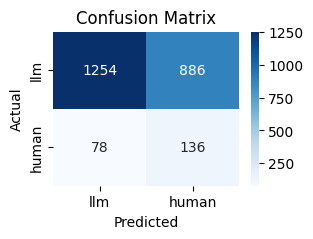

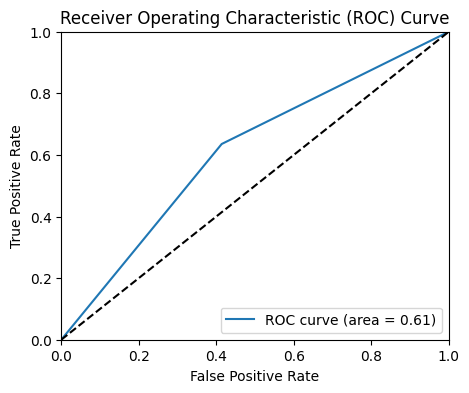

{'f1': 0.22006472491909382, 'roc_auc': 0.6107476635514019}

In [ ]:
df_jina = df[df['embedder_checkpoint'] == 'jinaai/jina-embeddings-v2-base-code']
preds = []
for i, row in tqdm(df_jina.iterrows()):
    input_embedding, generated_embeddings = sample_input_and_generated_for_index(df_jina,
                                                                                 index=row['index'],
                                                                                 col_name=row['col'],
                                                                                 n_samples=4)
    pred, _ = predict(input_embedding, generated_embeddings)
    preds.append(pred)

evaluate_predictions(df_jina['label'][:len(preds)], preds)